In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud

import re

import matplotlib.pyplot as plt
from collections import defaultdict

import pandas as pd
from collections import Counter

# Funciones

In [3]:
# Función para contar las palabras y dividirlas según la clasificación
def contar_palabras_por_clasificacion(df, columna_clasificacion, columna_texto):
    
    # Función para contar las palabras y dividirlas según la clasificación
    def contar_palabras(texto):
        # Dividir el texto en palabras
        palabras = texto.split()
        return Counter(palabras)

    # Aplicar la función a la columna 'Texto' para contar las palabras en cada texto
    conteo_total = df[columna_texto].apply(contar_palabras).sum()

    # Filtrar el DataFrame para las clasificaciones 'ham' y 'spam' y contar las palabras
    conteo_ham = df[df[columna_clasificacion] == 'ham'][columna_texto].apply(contar_palabras).sum()
    conteo_spam = df[df[columna_clasificacion] == 'spam'][columna_texto].apply(contar_palabras).sum()

    # Crear un DataFrame con los resultados
    df_resultado = pd.DataFrame({
        'Palabra': list(conteo_total.keys()),
        'Total': list(conteo_total.values()),
        'Ham': [conteo_ham[palabra] for palabra in conteo_total.keys()],
        'Spam': [conteo_spam[palabra] for palabra in conteo_total.keys()]
    })

    # Rellenar NaN con 0
    df_resultado.fillna(0, inplace=True)

    return df_resultado

#Funcion para generar nube de palabras
def word_cloud(diccionario, words, title):
    nube = WordCloud(max_words = words, background_color = "white", colormap = "copper_r").generate_from_frequencies(diccionario)
    plt.imshow(nube,interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()


# Limpieza de datos

In [4]:
file = "spam.csv"
data = pd.read_csv(file, encoding="latin1")
data = data.iloc[:, :-3]
data.shape

(5572, 2)

In [5]:
stop_words=set(stopwords.words('english'))

In [6]:
Filter_stopw = []
Len = []

for text in data.iloc[:,1]:
    word_tokens = word_tokenize(text) #Se separa en tokens todo el texto
    word_tokens = [re.sub(r'[^a-zA-Z0-9]', ' ', token) for token in word_tokens] #Se eliminan caracteres especiales

    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words] 
    filtered_sentence = []

    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)

        token2text = ' '.join(filtered_sentence)
    
    Len.append(len(filtered_sentence))
    Filter_stopw.append(token2text)

Filter_stopw
data['Stopwords']=Filter_stopw
data['Len']=Len

In [7]:
print(data.iloc[12,1])
print(data.iloc[12,2])

URGENT! You have won a 1 week FREE membership in our å£100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C www.dbuk.net LCCLTD POBOX 4403LDNW1A7RW18
URGENT   You 1 week FREE membership   100 000 Prize Jackpot   Txt word   CLAIM No   81010 T   C www dbuk net LCCLTD POBOX 4403LDNW1A7RW18


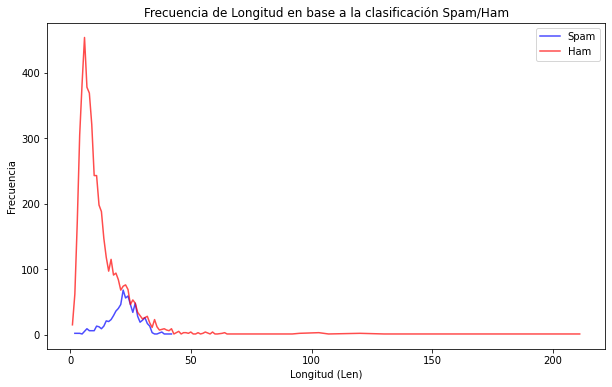

In [8]:
# Graficar los datos
plt.figure(figsize=(10, 6))

# Filtrar los datos para cada opción en la columna 'v1'
option_0 = data[data['v1'] == "spam"]['Len']
option_1 = data[data['v1'] == "ham"]['Len']

# Contar la frecuencia de cada valor de 'Len' para cada opción
counts_0 = option_0.value_counts().sort_index()
counts_1 = option_1.value_counts().sort_index()

# Graficar las frecuencias para cada opción
plt.plot(counts_0.index, counts_0.values, color='b', alpha=0.7, label='Spam')
plt.plot(counts_1.index, counts_1.values, color='r', alpha=0.7, label='Ham')

plt.xlabel('Longitud (Len)')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de Longitud en base a la clasificación Spam/Ham')
plt.legend()

plt.show()


In [9]:
resultado = contar_palabras_por_clasificacion(data, 'v1', 'Stopwords')

## Lematización

In [10]:
lemmatizer = WordNetLemmatizer()
lemmatization = []

#Primer For
for text in data.iloc[:,2]:
    #print(text)
    word_tokens = word_tokenize(text.lower())
    
    lemma_sentence = []

    for w in word_tokens:
        lemma = lemmatizer.lemmatize(w)

        #if lemma != w:
            #print(w)        
        
        lemma_sentence.append(lemma)

    list2text = " ".join(lemma_sentence)
    lemmatization.append(list2text)
    #print(list2text, "\n")

data['lemmatization'] = lemmatization

In [11]:
resultado_2 = contar_palabras_por_clasificacion(data, 'v1', 'lemmatization')

In [ ]:
max_words = 25
diccionario_total = dict(zip(resultado_2['Palabra'], resultado_2['Total']))
diccionario_ham = dict(zip(resultado_2['Palabra'], resultado_2['Ham']))
diccionario_spam = dict(zip(resultado_2['Palabra'], resultado_2['Spam']))

word_cloud(diccionario_total, max_words, "Nube de palabras. Sin considerar la clasificación")
word_cloud(diccionario_ham, max_words, "Nube de palabras. Clasificación HAM")
word_cloud(diccionario_spam, max_words, "Nube de palabras. Clasificación SPAM")

In [ ]:
TablaFrecuencia = resultado_2.sort_values(by='Ham', ascending=False).head(10)

print( TablaFrecuencia.to_latex(index=False,
                               caption="Comparativa de frecuencia de palabras en orden descentende, según Ham",
                               label="tab:frecuencia_ham",
                               position="htbp",
                               column_format="|l|l|l|l|",
                               escape=False
                               ))

# Modelo

In [12]:
X = data['lemmatization']
y = data['v1']

# entrenamiento y conjunto de prueba (80% para entrenamiento, 20% para prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

N_s_train = y_train.value_counts()['spam']
N_h_train = y_train.value_counts()['ham']

P_S_train = N_s_train / len(y_train)
P_H_train = N_h_train / len(y_train)

# Nw,s y Nw,h
word_counts_spam_train = {} 
word_counts_ham_train = {} 

for text, label in zip(X_train, y_train):
    words = text.split()
    for word in words:
        if label == 'spam':
            word_counts_spam_train[word] = word_counts_spam_train.get(word, 0) + 1
        else:
            word_counts_ham_train[word] = word_counts_ham_train.get(word, 0) + 1

#P(W|S) y P(W|H)
P_W_given_S_train = {}
P_W_given_H_train = {}

for word in word_counts_spam_train:
    P_W_given_S_train[word] = word_counts_spam_train[word] / N_s_train

for word in word_counts_ham_train:
    P_W_given_H_train[word] = word_counts_ham_train[word] / N_h_train

# P(W) para cada palabra en los datos de entrenamiento
P_W_train = {}
for word in word_counts_spam_train:
    if word in word_counts_ham_train:
        P_W_train[word] = (word_counts_spam_train[word] / N_s_train) / ((word_counts_ham_train[word] / N_h_train) + (word_counts_spam_train[word] / N_s_train))

# Probabilidad de que un texto sea SPAM dado que contiene la palabra W
def calculate_P_S_given_W_train(word):
    P_W_given_S = P_W_given_S_train.get(word, 0)
    P_W_given_H = P_W_given_H_train.get(word, 0)
    
    if P_W_given_S == 0 and P_W_given_H == 0:
        return 0  # Si la palabra no está presente en ningún conjunto, devolver 0
        
    numerator = P_W_given_S * P_S_train
    denominator = numerator + (P_W_given_H * P_H_train)
    
    if denominator == 0:
        return 0  
    
    return numerator / denominator


#Probabilidad de que un texto sea SPAM dado que contiene las n palabras
def calculate_P_S_given_W_text(text):
    probabilidades = []
    words = text.split()

    for word in words:
        Prob_W = calculate_P_S_given_W_train(word)
        probabilidades.append(Prob_W)
    
    probabilidades = [prob for prob in probabilidades if prob != 0]
    
    if probabilidades == []:
        return 0
    
    numerador = probabilidades[0]
    denominador = 1 - probabilidades[0]
    
    for prob in probabilidades[1:]:
        #print(numerador, denominador)
        numerador *= prob
        denominador *= (1 - prob)
    
    if denominador == 0 and numerador == 0:
        return 0

    return numerador / (numerador + denominador)


#Probabilidad P(W) por cada palabra
def calculateP_given_W(word):
    N_ws = word_counts_spam_train.get(word, 0)
    N_wh = word_counts_ham_train.get(word, 0)

    if N_ws == 0 and N_wh == 0:
        return 0
    
    numerator = N_ws / N_s_train
    denominator = (N_wh/N_h_train) + numerator

    if denominator == 0:
        return 0
    
    return numerator / denominator

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

predictions = []

for text in X_test:
    prob_spam = calculate_P_S_given_W_text(text)
    
    # Si la probabilidad es mayor que 0.5, clasifícalo como spam
    if prob_spam > 0.5:
        predictions.append('spam')
    else:
        predictions.append('ham')

# métricas de rendimiento
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, pos_label='spam')
recall = recall_score(y_test, predictions, pos_label='spam')
f1 = f1_score(y_test, predictions, pos_label='spam')
conf_matrix = confusion_matrix(y_test, predictions)

print("Accuracy:", accuracy)
print("Precision:", precision)  
print("Recall:", recall)
print("F1-score:", f1)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.9408071748878923
Precision: 0.7024390243902439
Recall: 0.9664429530201343
F1-score: 0.8135593220338984
Confusion Matrix:
[[905  61]
 [  5 144]]


In [13]:
import tkinter as tk
from tkinter import messagebox

def stopwords(text):
    word_tokens = word_tokenize(text) #Se separa en tokens todo el texto
    word_tokens = [re.sub(r'[^a-zA-Z0-9]', ' ', token) for token in word_tokens] #Se eliminan caracteres especiales

    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words] 
    filtered_sentence = []

    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)

    token2text = ' '.join(filtered_sentence)

    return token2text

#Limpieza
def Cleantxt(text):
    text = stopwords(text)

    word_tokn = word_tokenize(text.lower())
    
    lemma_sentence = []

    for w in word_tokn:
        lemma = lemmatizer.lemmatize(w)     
        lemma_sentence.append(lemma)

    list2text = " ".join(lemma_sentence)

    return list2text


In [16]:
# botón "Calcular Probabilidades"
def calcular_probabilidades():
    texto = texto_entry.get()
    texto_limpiado = Cleantxt(texto)
    proba = calculate_P_S_given_W_text(texto_limpiado)
    print("Probabilidad de ser SPAM",proba)

    probabilidades = []
    words = texto_limpiado.split()

    for word in words:
        P_W = calculateP_given_W(word)
        probabilidades.append((word, P_W))
        print(f"{word}: {P_W:.2f}")

    probabilidades_str = "\n".join([f"{word}: {P_W:.2f}" for word, P_W in probabilidades])

    mensaje = f"Probabilidad de spam: {proba:.2f}\n\nProbabilidades por palabra:\n{probabilidades_str}"
    messagebox.showinfo("Resultado", mensaje)
    

# Crear la ventana principal
ventana = tk.Tk()
ventana.title("Detector de Spam")

# Crear un widget de etiqueta para el título
titulo_label = tk.Label(ventana, text="Introduce el texto:", anchor="center", justify="center")
titulo_label.pack()

# Crear un widget de entrada de texto
texto_entry = tk.Entry(ventana, width=100)
texto_entry.pack()

# Crear un botón para calcular las probabilidades
calcular_button = tk.Button(ventana, text="Calcular Probabilidades", command=calcular_probabilidades)
calcular_button.pack()

# Ejecutar el bucle principal de la ventana
ventana.mainloop()

Probabilidad de ser SPAM 1.0
reminder: 0.93
you: 0.75
downloaded: 1.00
content: 0.96
already: 0.08
paid: 0.52
